In [1]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))

    return sdf_files

fragments = get_sdfs('Mpro_fragments')

# NOTE no sdf files in mpro_all that aren't in mpro_fragments - i.e. they're all fragments


convert sdf files to mol objects with coords

https://www.rdkit.org/docs/GettingStartedInPython.html

In [6]:
# get mol object for each sdf file
# NOTE just doing for fragments here (same files anyway in all vs frag)

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols

mols = sdf_to_mol(fragments)


extract pharmacophores
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [7]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

get pharmacophore coordinates

In [8]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


In [9]:
# compute pharmacophores coordinates
donor_coords = []
acceptor_coords = []
aromatic_coords = []

for mol in mols:
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords += [pharma_coords['Donor']]
    acceptor_coords += [pharma_coords['Acceptor']]
    #aromatic_coords += [pharma_coords['Aromatic']]
    
donor_coords = np.concatenate(donor_coords)
acceptor_coords = np.concatenate(acceptor_coords)
#aromatic_coords = np.concatenate(aromatic_coords)

# NOTE issue with aromatic - key error, just no aromatic ph4s?


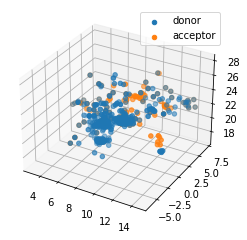

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')

# visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
ax.scatter3D(donor_coords[:,0], donor_coords[:,1], donor_coords[:,2], label="donor")
ax.scatter3D(acceptor_coords[:,0], acceptor_coords[:,1], acceptor_coords[:,2], label="acceptor")
#ax.scatter3D(aromatic_coords[:,0], aromatic_coords[:,1], aromatic_coords[:,2], label="aromatic")
plt.legend()
plt.show()


clustering?

query molecules: generating conformers

In [36]:
# get mol objects for query mols
query_sdfs = get_sdfs('Mpro_all') # NOTE not actual query mols atm?
query_mols = sdf_to_mol(query_sdfs)

# we will need to generate "ALL" possible conformers (3D) and check all
for mol in mols:
    molH = Chem.AddHs(mol) # NOTE why add hydrogens, don't know this
    # generate conformers
    confIds = AllChem.EmbedMultipleConfs(molH, numConfs=10, params=AllChem.ETKDG())


query_pharma_dict, __ = getPharmacophoreCoords(query_mols[0])
query_pharma_dict

# NOTE again shows no aromatic? 

[13:58:32] UFFTYPER: Unrecognized atom type: S_5+4 (0)
RDKit ERROR: [13:58:32] UFFTYPER: Unrecognized atom type: S_5+4 (0)
RDKit ERROR: [13:58:40] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[13:58:40] UFFTYPER: Unrecognized atom type: S_5+4 (1)
RDKit ERROR: [13:58:49] UFFTYPER: Unrecognized atom type: S_5+4 (19)
[13:58:49] UFFTYPER: Unrecognized atom type: S_5+4 (19)
RDKit ERROR: [13:58:57] UFFTYPER: Unrecognized atom type: S_5+4 (7)
[13:58:57] UFFTYPER: Unrecognized atom type: S_5+4 (7)
RDKit ERROR: [13:59:13] UFFTYPER: Unrecognized atom type: S_5+4 (0)
[13:59:13] UFFTYPER: Unrecognized atom type: S_5+4 (0)
RDKit ERROR: [13:59:14] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[13:59:14] UFFTYPER: Unrecognized atom type: S_5+4 (1)
RDKit ERROR: [13:59:23] UFFTYPER: Unrecognized atom type: S_5+4 (0)
[13:59:23] UFFTYPER: Unrecognized atom type: S_5+4 (0)
RDKit ERROR: [13:59:35] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[13:59:35] UFFTYPER: Unrecognized atom type: S_5+4 (1)


{'Donor': array([[ 6.583,  0.585, 17.389],
        [12.394,  0.612, 23.837],
        [ 7.444, -0.527, 20.799],
        [ 9.139,  0.973, 20.84 ]]),
 'Acceptor': array([[ 9.139,  0.973, 20.84 ]])}